In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

from copy import copy, deepcopy
from utils.classes import CellImage
from utils.helpers.helpers import get_images, show_images, show_plot_intensity_hists
from utils.helpers.enums import FilterAlg, ContoursDetectingAlg, MorphOperation, EdgesDetectingAlg, Pixel

In [2]:
subfolders = [f.path for f in os.scandir('./cells_images') if f.is_dir()]
folders_with_images = [[CellImage(image) for image in get_images(subfolder, limit=5)] for subfolder in subfolders]
for folder in folders_with_images:
    for image in folder:
        image.delete_description()
subfolders

['./cells_images/27_12_22_ps_v',
 './cells_images/Provotorova',
 './cells_images/Provotorova_13.12.22',
 './cells_images/28_12_22_ps_v']

In [121]:
def get_cells_using_sdb(image: CellImage):
    image.filter(alg=FilterAlg.GAUSSIAN)
    image.detect_contours(alg=ContoursDetectingAlg.OTSU_BINARIZATION)
    # image.morph_transform(alg=MorphOperation.EROSION, kernel=np.ones((5, 5), np.uint8), iterations=3)
    contours, _ = cv.findContours(image.src, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    noiseless_mask = np.full_like(image.src, 0)
    cv.fillPoly(noiseless_mask, contours, 255)
    image_rgb = cv.cvtColor(noiseless_mask, cv.COLOR_GRAY2RGB)

    for contour in contours:
        x, y, width, height = cv.boundingRect(contour)
        cv.rectangle(image_rgb, (x, y), (x + width, y + height), (0, 255, 0), 1)
        rect = cv.minAreaRect(contour)
        box = cv.boxPoints(rect)
        box = np.int0(box)
        cv.drawContours(image_rgb,[box],0,(255,0,0),2)

    #for contour in contours:
     #   if len(contour) > 4:    
      #      ((centx,centy), (width,height), angle) = cv.fitEllipse(contour)
       #     cv.ellipse(image_rgb, (int(centx),int(centy)), (int(width/2), int(height/2)), int(angle), 0, 360, (0,255,0), 5)

    return image_rgb

In [122]:
def show_images_with_their_masks(images: list[CellImage]):
    copied_images = deepcopy(images)
    originals = [(image.src, 'original') for image in copied_images]
    masks = [(get_cells_using_sdb(image), 'mask') for image in copied_images]
    show_images([
      *originals,
      *masks
    ], grid=(2, len(copied_images)), size_inches=(25, 8))

/tmp/ipykernel_13/2462608350.py:16: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


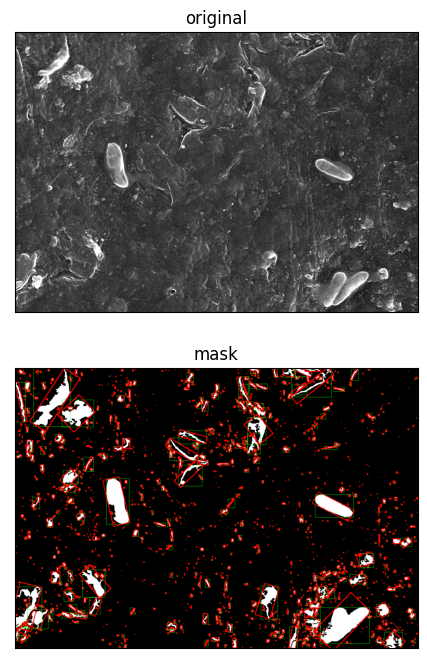

In [123]:
show_images_with_their_masks([folders_with_images[1][1]])